In [ ]:
import numpy as np
import pandas as pd
import gc
import os
import random

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pandas.plotting import scatter_matrix

In [ ]:
# Import merged data set created at the end of G25_01_Descriptive_Analysis_Cleansing_Preprocessing.ipynb
df_train_merge = pd.read_csv("merged_data.zip")

In [ ]:
# Check all rows of data have been loaded for df_train_merge data set
expected_rows = 19835460
 
if len(df_train_merge) == expected_rows:
  print(f'All {expected_rows} rows of df_train_merge have been imported')
else:
  print(f'WARNING: Only {len(df_train_merge)} rows imported, expected {expected_rows}')

All 19835460 rows of df_train_merge have been imported


In [ ]:
#Code from https://www.kaggle.com/zeynepkurban/ashrae-2/notebook
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
df_train_merge = reduce_mem_usage(df_train_merge)

Memory usage after optimization is: 605.33 MB
Decreased by 73.3%


In [ ]:
X_train = df_train_merge

In [ ]:
del df_train_merge

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

In [ ]:
# Seperate categorical features
categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday", "day", "month", "meter_reading", "timestamp"]
# In here, I put meter_readings and timestamp in categorical_features. Of course they are not categoric, I just store them in there.
X_train_categorical = X_train[categorical_features]
X_train_categorical = reduce_mem_usage(X_train_categorical)

# Seperate numerical features
numerical_features = ["air_temperature", "cloud_coverage", "dew_temperature", 
                      "precip_depth_1_hr", "square_feet"]
X_train_numerical = X_train[numerical_features]

#X_train_numerical = reduce_mem_usage(X_train_numerical)

minmaxscaler = MinMaxScaler()
powertransformer = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_numerical = minmaxscaler.fit_transform(X_train_numerical)
X_train_numerical = powertransformer.fit_transform(X_train_numerical)
X_train_numerical = pd.DataFrame(X_train_numerical, columns= numerical_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Memory usage after optimization is: 397.25 MB
Decreased by 0.0%


In [ ]:
X_train_categorical = X_train_categorical.reset_index(drop= True)
X_train_numerical = X_train_numerical.reset_index(drop= True)

In [ ]:
# Merge the dataset again
X_train = X_train_categorical

X_train["air_temperature"] = X_train_numerical.air_temperature
X_train["cloud_coverage"] = X_train_numerical.cloud_coverage
X_train["dew_temperature"] = X_train_numerical.dew_temperature
X_train["precip_depth_1_hr"] = X_train_numerical.precip_depth_1_hr
X_train["square_feet"] = X_train_numerical.square_feet

In [ ]:
del X_train_categorical, X_train_numerical

In [ ]:
# Apply log transform to meter_reading feature
X_train['meter_reading'] = np.log1p(X_train['meter_reading'])

In [ ]:
# Now, we are starting to format our dataset to make it suitable to ltsm keras

In [ ]:
X_train = X_train.reset_index().drop("index",1)
X_train = reduce_mem_usage(X_train)

Memory usage after optimization is: 548.58 MB
Decreased by 52.5%


In [ ]:
X_train_other_lstm_model = X_train

In [ ]:
train_dataset = X_train
del X_train

In [ ]:
# In there, we are creating new featuers as t-4, t-3, t-2 and t-1. Then, We will use these features to feed our dataset. 
# We take buildings one by one and also sort them as their meter type.
dataframe = pd.DataFrame()
for building in train_dataset["building_id"].unique():
    df = pd.DataFrame()
    meter_types = train_dataset[train_dataset.building_id == building].meter.unique()
    for i in meter_types:
        df_meter = pd.DataFrame()
        df_meter = train_dataset[(train_dataset.building_id == building) & (train_dataset.meter == i)].sort_values("timestamp").reset_index().drop("index",1).loc[4:,]
        df_meter["t-4"] = train_dataset[(train_dataset.building_id == building) & (train_dataset.meter == i)].sort_values("timestamp").reset_index().drop("index",1)[:-4]["meter_reading"].values
        df_meter["t-3"] = train_dataset[(train_dataset.building_id == building) & (train_dataset.meter == i)].sort_values("timestamp").reset_index().drop("index",1)[1:-3]["meter_reading"].values
        df_meter["t-2"] = train_dataset[(train_dataset.building_id == building) & (train_dataset.meter == i)].sort_values("timestamp").reset_index().drop("index",1)[2:-2]["meter_reading"].values
        df_meter["t-1"] = train_dataset[(train_dataset.building_id == building) & (train_dataset.meter == i)].sort_values("timestamp").reset_index().drop("index",1)[3:-1]["meter_reading"].values
        df = pd.concat([df,df_meter])
        
    dataframe = pd.concat([dataframe,df])

In [ ]:
# Sort the dataset by timestamp.
dataframe = dataframe.sort_values("timestamp")

In [ ]:
dataframe_saved = dataframe

**Two inputs, One output model**

In [ ]:
# Lets divide the dataframe. First 80% will be used for training and last 20% will be used for testing and validating.
X_train = dataframe[:int(dataframe.shape[0]*4 / 5)]
X_val = dataframe[int(dataframe.shape[0]*8 / 10):int(dataframe.shape[0]*9 / 10)]
X_test = dataframe[int(dataframe.shape[0]*9 / 10):]

In [ ]:
# Now, we split the dataset by 2. We will feed our keras model with 2 different datasets.
# At first,lets create lstm dataset
dataframe_lstm = X_train[["t-4", "t-3", "t-2", "t-1", "meter_reading"]].reset_index().drop("index",1)
dataframe_val_lstm = X_val[["t-4", "t-3", "t-2", "t-1", "meter_reading"]].reset_index().drop("index",1)
dataframe_test_lstm = X_test[["t-4", "t-3", "t-2", "t-1", "meter_reading"]].reset_index().drop("index",1)

In [ ]:
# Now, create normal dataset with
dataframe_normal = X_train.drop(["t-4", "t-3", "t-2", "t-1"],1).reset_index().drop("index",1)
dataframe_val_normal = X_val.drop(["t-4", "t-3", "t-2", "t-1"],1).reset_index().drop("index",1)
dataframe_test_normal = X_test.drop(["t-4", "t-3", "t-2", "t-1"],1).reset_index().drop("index",1)

In [ ]:
# We save and download these datasets because neural network process consume lots of memory and generally crash because of lack of ram.
# So we will download these outputs and use them in different notebook to complete neural network process
#dataframe_lstm.to_csv('dataframe_ltsm.csv',index=False)
#dataframe_test_lstm.to_csv('dataframe_test_ltsm.csv',index=False)
#dataframe_normal.to_csv('dataframe_normal.csv',index=False)
#dataframe_test_normal.to_csv('dataframe_test_normal.csv',index=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
dataframe_test_lstm

,t-4,t-3,t-2,t-1,meter_reading
0,2.845703,2.839844,3.191406,3.214844,3.226562
1,3.970703,3.945312,3.875000,3.873047,4.046875
2,4.406250,4.433594,4.449219,4.410156,4.449219
3,0.481689,0.595215,0.517578,0.598145,0.467529
4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
1982591,2.923828,2.935547,2.861328,2.921875,2.904297
1982592,5.503906,5.429688,5.558594,5.214844,5.011719
1982593,1.481445,1.503906,1.458984,1.547852,1.526367
1982594,7.390625,7.503906,7.457031,7.464844,7.457031


In [ ]:
# make dataframes suitable for lstm
values_train = dataframe_lstm.values
values_val = dataframe_val_lstm.values
values_test = dataframe_test_lstm.values
features = len(dataframe_lstm.columns) - 1

train_X, train_y = values_train[:, :-1], values_train[:, -1]
val_X, val_y = values_val[:, :-1], values_val[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, features))
val_X = val_X.reshape((val_X.shape[0], 1, features))
test_X = test_X.reshape((test_X.shape[0], 1, features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(15860764, 1, 4) (15860764,) (1982596, 1, 4) (1982596,) (1982596, 1, 4) (1982596,)


In [ ]:
del dataframe_lstm, dataframe_test_lstm, dataframe_val_lstm

In [ ]:
# Drop "meter_reading" feature in these dataset. We already collect them in train_y, and test_y
dataframe_normal = dataframe_normal.drop(["meter_reading", "timestamp"],1)
dataframe_val_normal = dataframe_val_normal.drop(["meter_reading", "timestamp"],1)
dataframe_test_normal = dataframe_test_normal.drop(["meter_reading", "timestamp"],1)

In [ ]:
# Lets create our model. We have 2 different datasets and we will feed model with them. We are using keras functional api.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import concatenate

input_lstm = Input(shape=(train_X.shape[1], train_X.shape[2]), name='input_lstm')
input_nn = Input(shape=(len(dataframe_normal.columns),), name='input_nn')

# middle layers
lstm_1 = LSTM(50, activation='relu')(input_lstm)
#lstm_2 = Dropout(0.2)(lstm_1)
lstm_3 = Dense(50, activation='relu')(lstm_1)
#lstm_4 = Dropout(0.2)(lstm_3)

nn_1 = Dense(150, activation='relu')(input_nn)
nn_2 = Dense(300, activation='relu')(nn_1)

c = concatenate([nn_2, lstm_3])

outputs = Dense(1, name='outputs')(c)

LTSM_NN_01_model = Model(inputs=[input_nn, input_lstm], outputs=outputs)

In [ ]:
LTSM_NN_01_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nn (InputLayer)           [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_lstm (InputLayer)         [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          2100        input_nn[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50)           11000       input_lstm[0][0]                 
______________________________________________________________________________________________

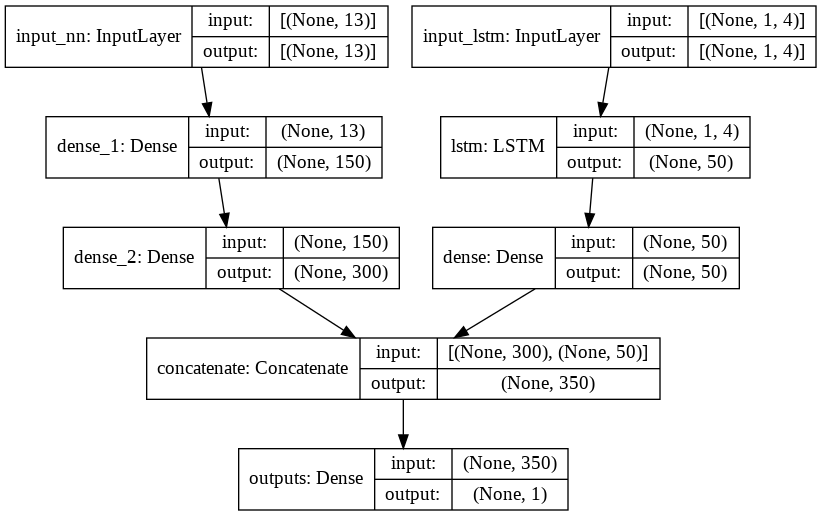

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(LTSM_NN_01_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
import keras
from keras.losses import mean_squared_error
from tensorflow.keras import backend as K

# We want to use rmse for loss function but keras have only mse. So lets create our own funtion for rmse and use it as a loss function.
# https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 



In [ ]:
LTSM_NN_01_model.compile(
    optimizer='adam',
    loss= root_mean_squared_error,
     metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

In [ ]:
LTSM_NN_01_history = LTSM_NN_01_model.fit([dataframe_normal, train_X], train_y, validation_data=([dataframe_val_normal, val_X], val_y), epochs= 2)

Epoch 1/2
495649/495649 [==============================] - 1057s 2ms/step - loss: 0.4984 - rmse: 0.7178 - val_loss: 0.3984 - val_rmse: 0.5010
Epoch 2/2
495649/495649 [==============================] - 1061s 2ms/step - loss: 0.4201 - rmse: 0.5236 - val_loss: 0.3998 - val_rmse: 0.5022


In [ ]:
y_pred = LTSM_NN_01_model.predict([dataframe_test_normal, test_X])

In [ ]:
from sklearn.metrics import r2_score
r2_score(test_y, y_pred)

0.956032963839012

In [ ]:
#y_pred

In [ ]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_y, y_pred, squared=True);rmse

0.19745643

In [ ]:
# mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred, squared = False);mse

0.4443607

In [ ]:
y_prediction = list(map(float, y_pred))

In [ ]:
pred_dataset = pd.DataFrame()
pred_dataset["meter_reading_pred"] = y_prediction
pred_dataset["timestamp"] = X_test.timestamp.values

In [ ]:
real_dataset = pd.DataFrame()
real_dataset["meter_reading_real"] = test_y
real_dataset["timestamp"] = X_test.timestamp.values

In [ ]:
from matplotlib import pyplot as plt

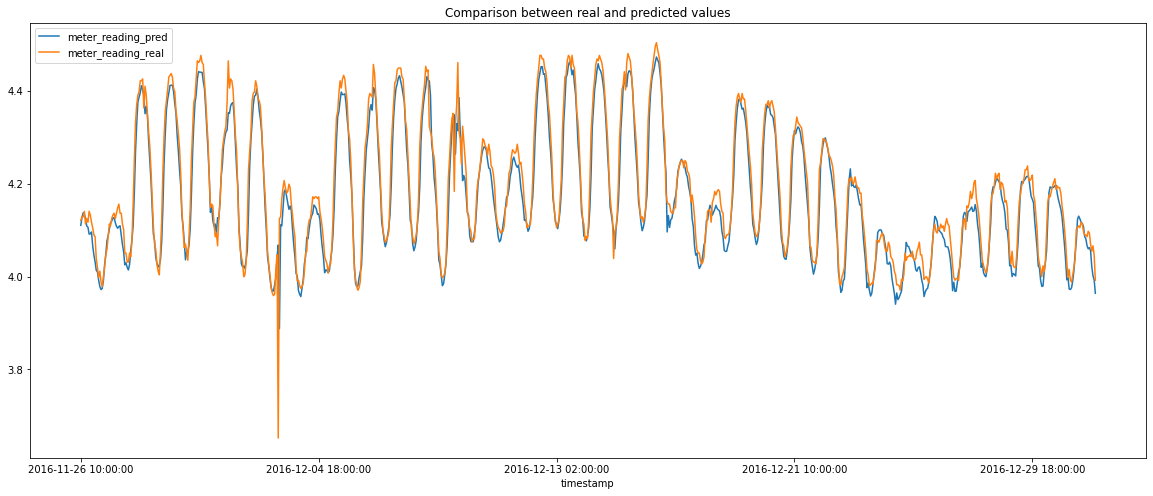

In [ ]:
y_mean_time_pred = pred_dataset.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = real_dataset.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

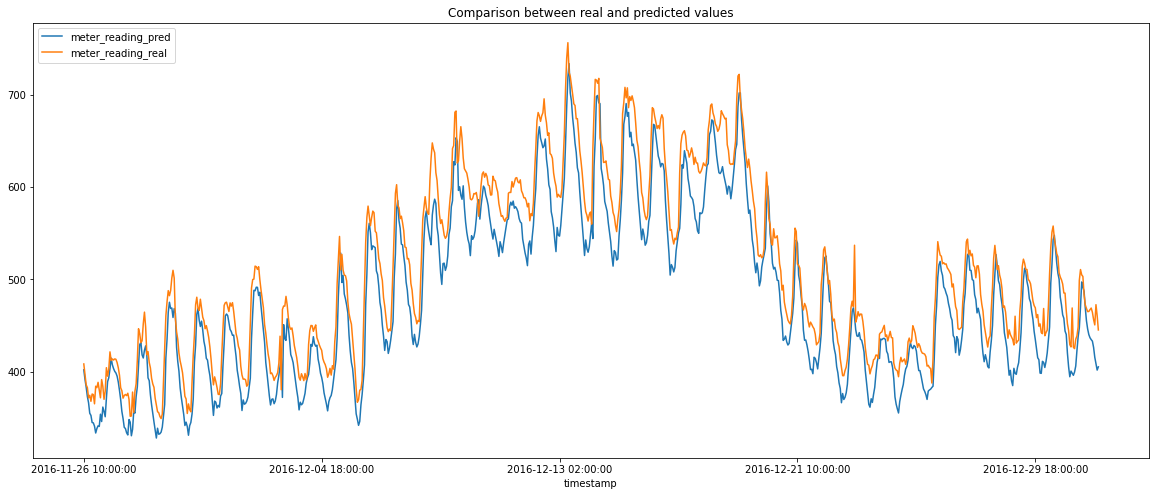

In [ ]:
test_y = test_y.astype("float32")
# inverse log1p function and plot it again
pred_dataset = pd.DataFrame()
pred_dataset["meter_reading_pred"] = np.expm1(y_prediction)
pred_dataset["timestamp"] = X_test.timestamp.values

real_dataset = pd.DataFrame()
real_dataset["meter_reading_real"] = np.expm1(test_y)
real_dataset["timestamp"] = X_test.timestamp.values

y_mean_time_pred = pred_dataset.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = real_dataset.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

**Two inputs one output model for just one building_id**

In [ ]:
# Just try with one buildin_id and one meter type

In [ ]:
#dataframe = pd.read_csv("dataframe_ltsm.csv.zip")

In [ ]:
# Lets filter dataset and just choose building_id = 1 and meter = 0.
dataframe = dataframe_saved
dataframe = dataframe[(dataframe.building_id == 1) & (dataframe.meter == 0)]
# Sort the dataset by timestamp.
dataframe = dataframe.sort_values("timestamp")

In [ ]:
# Lets divide the dataframe. First 80% will be used for training and last 20% will be used for testing and validating.
X_train = dataframe[:int(dataframe.shape[0]*4 / 5)]
X_val = dataframe[int(dataframe.shape[0]*8 / 10):int(dataframe.shape[0]*9 / 10)]
X_test = dataframe[int(dataframe.shape[0]*9 / 10):]

In [ ]:
# Now, we split the dataset by 2. We will feed our keras model with 2 different datasets.
# At first,lets create lstm dataset
dataframe_lstm = X_train[["t-4", "t-3", "t-2", "t-1", "meter_reading"]].reset_index().drop("index",1)
dataframe_val_lstm = X_val[["t-4", "t-3", "t-2", "t-1", "meter_reading"]].reset_index().drop("index",1)
dataframe_test_lstm = X_test[["t-4", "t-3", "t-2", "t-1", "meter_reading"]].reset_index().drop("index",1)

In [ ]:
# Now, create normal dataset with
dataframe_normal = X_train.drop(["t-4", "t-3", "t-2", "t-1"],1).reset_index().drop("index",1)
dataframe_val_normal = X_val.drop(["t-4", "t-3", "t-2", "t-1"],1).reset_index().drop("index",1)
dataframe_test_normal = X_test.drop(["t-4", "t-3", "t-2", "t-1"],1).reset_index().drop("index",1)

In [ ]:
values_train = dataframe_lstm.values
values_val = dataframe_val_lstm.values
values_test = dataframe_test_lstm.values
features = len(dataframe_lstm.columns) - 1

train_X, train_y = values_train[:, :-1], values_train[:, -1]
val_X, val_y = values_val[:, :-1], values_val[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, features))
val_X = val_X.reshape((val_X.shape[0], 1, features))
test_X = test_X.reshape((test_X.shape[0], 1, features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(4335, 1, 4) (4335,) (542, 1, 4) (542,) (542, 1, 4) (542,)


In [ ]:
# Drop "meter_reading" feature in these dataset. We already collect them in train_y, and test_y
dataframe_normal = dataframe_normal.drop(["meter_reading", "timestamp"],1)
dataframe_val_normal = dataframe_val_normal.drop(["meter_reading", "timestamp"],1)
dataframe_test_normal = dataframe_test_normal.drop(["meter_reading", "timestamp"],1)

In [ ]:
# This model structure is same with above but we increase the power of model
input_lstm = Input(shape=(train_X.shape[1], train_X.shape[2]), name='input_lstm')
input_nn = Input(shape=(len(dataframe_normal.columns),), name='input_nn')

# middle layers
lstm_1 = LSTM(150, activation='relu')(input_lstm)
#lstm_2 = Dropout(0.2)(lstm_1)
lstm_3 = Dense(150, activation='relu')(lstm_1)
#lstm_4 = Dropout(0.2)(lstm_3)

nn_1 = Dense(300, activation='relu')(input_nn)
nn_2 = Dense(300, activation='relu')(nn_1)

c = concatenate([nn_2, lstm_3])

outputs = Dense(1, name='outputs')(c)

LTSM_NN_02_model = Model(inputs=[input_nn, input_lstm], outputs=outputs)

In [ ]:
# We want to use rmse for loss function but keras have only mse. So lets create our own funtion for rmse and use it as a loss function.
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
LTSM_NN_02_model.compile(
    optimizer='adam',
    loss= root_mean_squared_error,
     metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

In [ ]:
LTSM_NN_02_history = LTSM_NN_02_model.fit([dataframe_normal, train_X], train_y, validation_data=([dataframe_val_normal, val_X], val_y), epochs= 50)

Epoch 1/50
136/136 [==============================] - 3s 9ms/step - loss: 0.8859 - rmse: 1.0944 - val_loss: 0.2727 - val_rmse: 0.2768
Epoch 2/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1823 - rmse: 0.1960 - val_loss: 0.2090 - val_rmse: 0.2149
Epoch 3/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1748 - rmse: 0.1951 - val_loss: 0.1682 - val_rmse: 0.1770
Epoch 4/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1454 - rmse: 0.1697 - val_loss: 0.1531 - val_rmse: 0.1620
Epoch 5/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1218 - rmse: 0.1400 - val_loss: 0.1717 - val_rmse: 0.1785
Epoch 6/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1230 - rmse: 0.1468 - val_loss: 0.1602 - val_rmse: 0.1697
Epoch 7/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1187 - rmse: 0.1464 - val_loss: 0.1589 - val_rmse: 0.1663
Epoch 8/50
136/136 [==============================] - 1s 7ms/s

In [ ]:
y_pred = LTSM_NN_02_model.predict([dataframe_test_normal, test_X])

In [ ]:
# mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred, squared = False);mse

0.31782115

In [ ]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_y, y_pred, squared=True);rmse

0.10101028

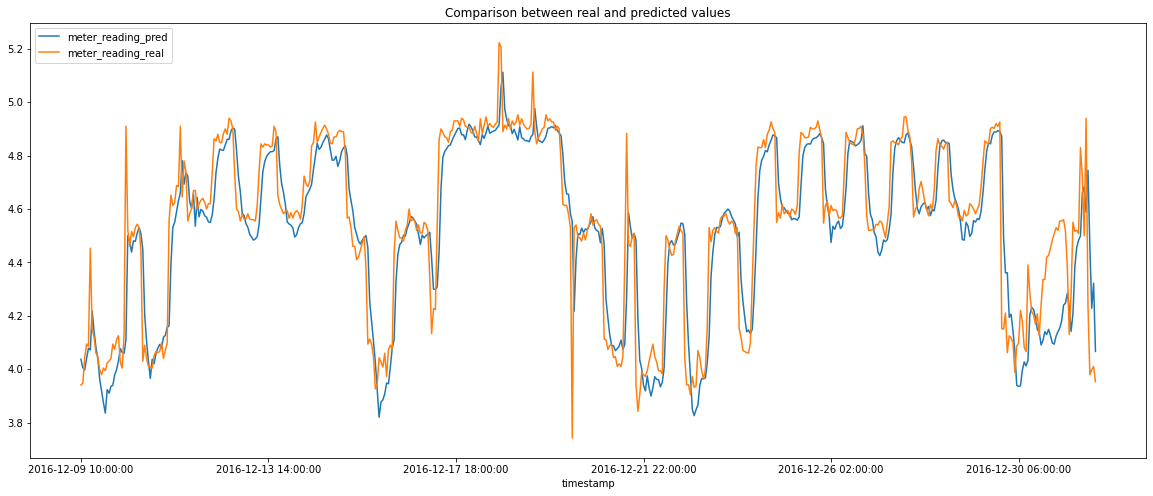

In [ ]:
test_y = test_y.astype("float32")
# inverse log1p function and plot it again
pred_dataset = pd.DataFrame()
pred_dataset["meter_reading_pred"] = (y_prediction)
pred_dataset["timestamp"] = X_test.timestamp.values

real_dataset = pd.DataFrame()
real_dataset["meter_reading_real"] = (test_y)
real_dataset["timestamp"] = X_test.timestamp.values

y_mean_time_pred = pred_dataset.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = real_dataset.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

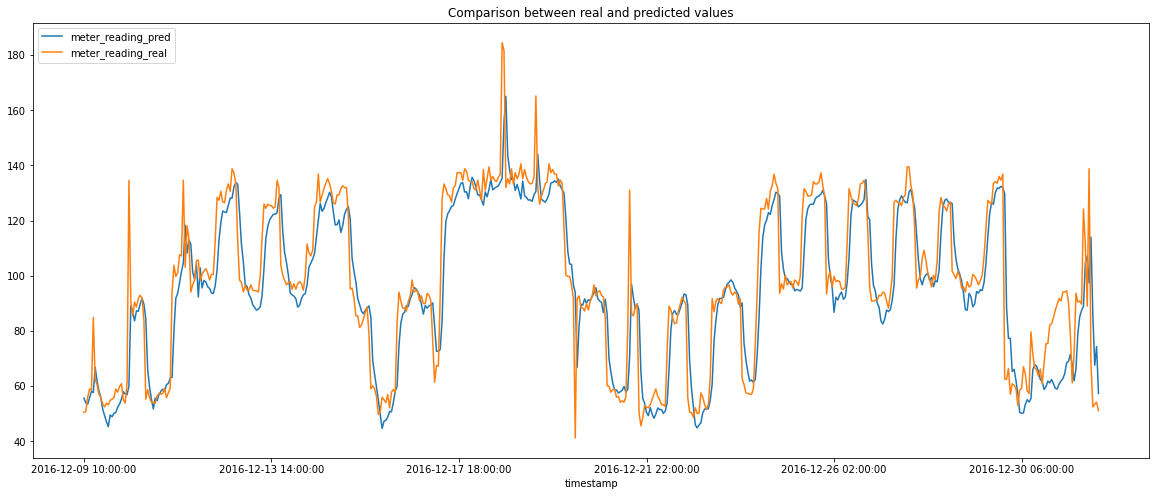

In [ ]:
test_y = test_y.astype("float32")
# inverse log1p function and plot it again
pred_dataset = pd.DataFrame()
pred_dataset["meter_reading_pred"] = np.expm1(y_prediction)
pred_dataset["timestamp"] = X_test.timestamp.values

real_dataset = pd.DataFrame()
real_dataset["meter_reading_real"] = np.expm1(test_y)
real_dataset["timestamp"] = X_test.timestamp.values

y_mean_time_pred = pred_dataset.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = real_dataset.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

In [ ]:
# Unlike our first prediction, now we will use our "t-4", "t-3", "t-2", "t-1" dataset with using our model.  In the first model, we used the real values and this highly effect our predictions.
# It fits perfectly which is unrealistic in real cases.

# This time,  I will take last four value of validation "meter_reading" as input and starting from it, model will produce all predictions one by one.  
# It is very close to real world example because this time, we will not use any real value as an input. Our inputs will be also prediction coming from previous prediction.


arr = [] # I will collect predictions in this list.

# These values are last 4 values coming from validation.
updated_t_1 = 4.812
updated_t_2 = 6.223
updated_t_3 = 7.434
updated_t_4 = 5.215

for i in range(0, len(test_X)):

  test_X[i][0][0] = updated_t_1
  test_X[i][0][1] = updated_t_2
  test_X[i][0][2] = updated_t_3
  test_X[i][0][3] = updated_t_4
  result = LTSM_NN_02_model.predict([dataframe_test_normal.iloc[i:i+1,], test_X[i].reshape(1,1,4)])[0][0] # make prediction

  # shift the inputs
  updated_t_1 = result
  updated_t_2 = updated_t_1
  updated_t_3 = updated_t_2
  updated_t_4 = updated_t_3
  
  #save the current prediction
  arr.append(result)

In [ ]:
#  mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, arr, squared=True);mse

0.13386247

In [ ]:
#  root mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, arr, squared=False);mse

0.3658722

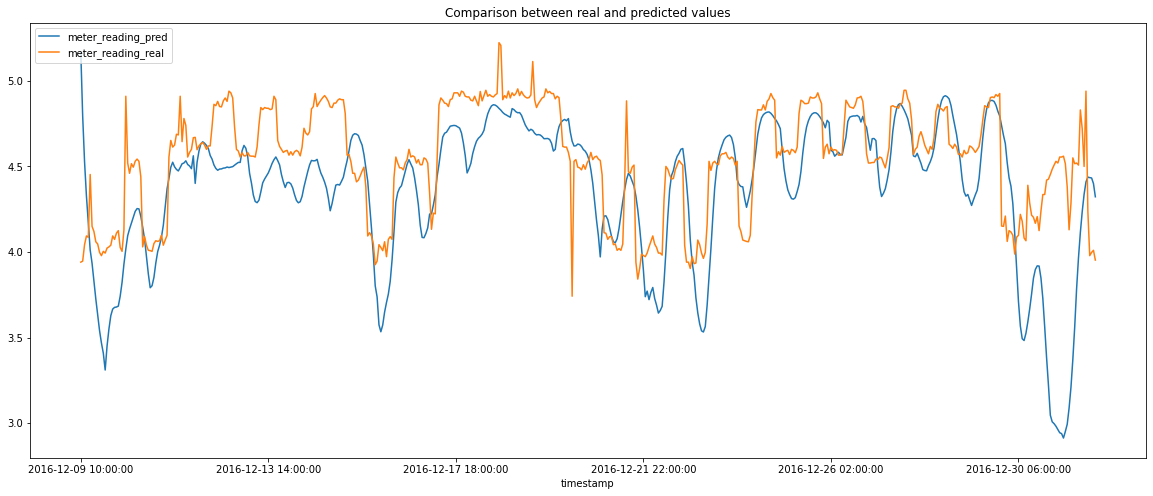

In [ ]:
test_y = test_y.astype("float32")
# inverse log1p function and plot it again
pred_dataset = pd.DataFrame()
pred_dataset["meter_reading_pred"] = (arr)
pred_dataset["timestamp"] = X_test.timestamp.values

real_dataset = pd.DataFrame()
real_dataset["meter_reading_real"] = (test_y)
real_dataset["timestamp"] = X_test.timestamp.values

y_mean_time_pred = pred_dataset.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = real_dataset.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

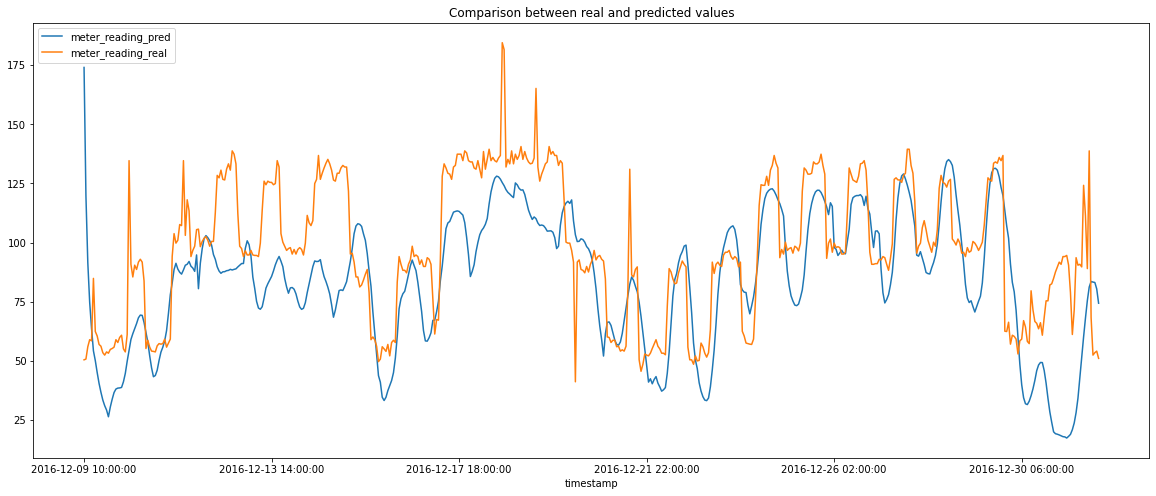

In [ ]:
# Now plot it without log transformation
test_y = test_y.astype("float32")
# inverse log1p function and plot it again
pred_dataset = pd.DataFrame()
pred_dataset["meter_reading_pred"] = np.expm1(arr)
pred_dataset["timestamp"] = X_test.timestamp.values

real_dataset = pd.DataFrame()
real_dataset["meter_reading_real"] = np.expm1(test_y)
real_dataset["timestamp"] = X_test.timestamp.values

y_mean_time_pred = pred_dataset.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = real_dataset.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

**LSTM with Sequential API**

In [ ]:
# Normal LSTM

In [ ]:
# Sort the dataset by timestamp.
dataframe = dataframe_saved
dataframe = train_dataset.sort_values("timestamp")

In [ ]:
df_meter_reading = train_dataset.meter_reading.values

In [ ]:
dataframe = dataframe.drop(["meter_reading"], 1)
dataframe["meter_reading"] = df_meter_reading

In [ ]:
# Lets divide the dataframe. First 80% will be used for training and last 20% will be used for testing and validating.
X_train_df = dataframe[:int(dataframe.shape[0]*4 / 5)]
X_val_df = dataframe[int(dataframe.shape[0]*4 / 5):int(dataframe.shape[0]*9 / 10)]
X_test_df = dataframe[int(dataframe.shape[0]*9 / 10):]

In [ ]:
X_test_df.timestamp

In [ ]:
values_train = X_train_df.values
values_val = X_val_df.values
values_test = X_test_df.values

features = len(X_train_df.columns) - 1

train_X, train_y = values_train[:, :-1], values_train[:, -1]
val_X, val_y = values_val[:, :-1], values_val[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]

print(train_X.shape, val_X.shape, test_X.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, features))
val_X = val_X.reshape((val_X.shape[0], 1, features))
test_X = test_X.reshape((test_X.shape[0], 1, features))

print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(15868368, 14) (1983546, 14) (1983546, 14)
(15868368, 1, 14) (15868368,) (1983546, 1, 14) (1983546,) (1983546, 1, 14) (1983546,)


In [ ]:
import keras
from keras.losses import mean_squared_error
from tensorflow.keras import backend as K

# We want to use rmse for loss function but keras have only mse. So lets create our pwn funtion for rmse and use it as loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(units = 50))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=150, validation_data=(val_X, val_y), shuffle=False)



Epoch 1/5
105790/105790 [==============================] - 930s 9ms/step - loss: 2.0665 - rmse: 2.1126 - val_loss: 2.0124 - val_rmse: 2.0417
Epoch 2/5
105790/105790 [==============================] - 957s 9ms/step - loss: 2.0590 - rmse: 2.1035 - val_loss: 2.0118 - val_rmse: 2.0410
Epoch 3/5
105790/105790 [==============================] - 999s 9ms/step - loss: 2.0589 - rmse: 2.1033 - val_loss: 2.0116 - val_rmse: 2.0408
Epoch 4/5
105790/105790 [==============================] - 1052s 10ms/step - loss: 2.0586 - rmse: 2.1031 - val_loss: 2.0111 - val_rmse: 2.0413
Epoch 5/5
105790/105790 [==============================] - 1081s 10ms/step - loss: 2.0577 - rmse: 2.1021 - val_loss: 2.0096 - val_rmse: 2.0393


In [ ]:
y_pred = model.predict(test_X)

In [ ]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_y, y_pred, squared=True);rmse

4.4797783

In [ ]:
# mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred, squared = False);mse

2.1165488

**LSTM Model with 4 feature**

In [ ]:
# This model is very similar with notebook tat we practised in the lesson. It take 4 feature and 4 timestamp depth.
# Then we apply series to supervised method.

In [ ]:
X_train_other_lstm_model.head()

,building_id,site_id,meter,primary_use,hour,weekday,day,month,meter_reading,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,square_feet
0,105,1,0,0,0,4,1,1,3.191406,2016-01-01 00:00:00,-1.104492,-1.107422,-0.589355,-0.113403,-0.467041
1,106,1,0,0,0,4,1,1,0.318115,2016-01-01 00:00:00,-1.104492,-1.107422,-0.589355,-0.113403,-1.516602
2,106,1,3,0,0,4,1,1,0.000000,2016-01-01 00:00:00,-1.104492,-1.107422,-0.589355,-0.113403,-1.516602
3,107,1,0,0,0,4,1,1,5.171875,2016-01-01 00:00:00,-1.104492,-1.107422,-0.589355,-0.113403,0.281250
4,108,1,0,0,0,4,1,1,4.523438,2016-01-01 00:00:00,-1.104492,-1.107422,-0.589355,-0.113403,0.057251


In [ ]:
 values = X_train_other_lstm_model[["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"]].values

In [ ]:
results = X_train_other_lstm_model.meter_reading.values

In [ ]:
values

array([[-1.1045, -1.107 , -0.5894, -0.1134],
       [-1.1045, -1.107 , -0.5894, -0.1134],
       [-1.1045, -1.107 , -0.5894, -0.1134],
       ...,
       [-1.2705,  0.196 , -1.274 , -2.242 ],
       [-1.2705,  0.196 , -1.274 , -2.242 ],
       [-1.2705,  0.196 , -1.274 , -2.242 ]], dtype=float16)

In [ ]:
# split into trainind and test datasets
ratio = round(0.8*values.shape[0])
train_values = values[:ratio, :]
test_values = values[ratio:, :]
print('trainind data size: ', train_values.shape, '\n    test data size: ', test_values.shape)

trainind data size:  (15868368, 4) 
    test data size:  (3967092, 4)


In [ ]:
# split into trainind and test datasets
ratio = round(0.8*values.shape[0])
train_y = results[:ratio]
test_y = results[ratio:]
print('trainind data size: ', train_y.shape, '\n    test data size: ', test_y.shape)

trainind data size:  (15868368,) 
    test data size:  (3967092,)


In [ ]:
test_timestamp = X_train_other_lstm_model.timestamp[ratio:]

In [ ]:
from pandas import concat

# convert series to supervised learning by Jason Brownlee 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# normalize features
lags = 4
features = train_values.shape[1]
print(lags, features)
 
# frame as supervised learning
train_reframed = series_to_supervised(train_values, lags, 1)
# drop columns we don't want to predict
train_reframed.drop(train_reframed.columns[[-1]], axis=1, inplace=True)
train_reframed.drop(train_reframed.columns[[-1]], axis=1, inplace=True)
train_reframed.drop(train_reframed.columns[[-1]], axis=1, inplace=True)
train_reframed.drop(train_reframed.columns[[-1]], axis=1, inplace=True)

test_reframed = series_to_supervised(test_values, lags, 1)
test_reframed.drop(test_reframed.columns[[-1]], axis=1, inplace=True)
test_reframed.drop(test_reframed.columns[[-1]], axis=1, inplace=True)
test_reframed.drop(test_reframed.columns[[-1]], axis=1, inplace=True)
test_reframed.drop(test_reframed.columns[[-1]], axis=1, inplace=True)


print(train_reframed.head())
print(test_reframed.head())

4 4
   var1(t-4)  var2(t-4)  var3(t-4)  ...  var2(t-1)  var3(t-1)  var4(t-1)
4  -1.104492  -1.107422  -0.589355  ...  -1.107422  -0.589355  -0.113403
5  -1.104492  -1.107422  -0.589355  ...  -1.107422  -0.589355  -0.113403
6  -1.104492  -1.107422  -0.589355  ...  -1.107422  -0.589355  -0.113403
7  -1.104492  -1.107422  -0.589355  ...  -1.107422  -0.589355  -0.113403
8  -1.104492  -1.107422  -0.589355  ...  -1.107422  -0.589355  -0.113403

[5 rows x 16 columns]
   var1(t-4)  var2(t-4)  var3(t-4)  ...  var2(t-1)  var3(t-1)  var4(t-1)
4  -0.735352   0.196045  -0.069763  ...   0.196045  -0.069763  -2.242188
5  -0.735352   0.196045  -0.069763  ...   0.196045  -0.069763  -2.242188
6  -0.735352   0.196045  -0.069763  ...   0.196045  -0.069763  -2.242188
7  -0.735352   0.196045  -0.069763  ...   0.196045  -0.069763  -2.242188
8  -0.735352   0.196045  -0.069763  ...   0.196045  -0.069763  -2.242188

[5 rows x 16 columns]


In [ ]:
train_y = (train_y[4:])
test_y = (test_y[4:])

In [ ]:
train_y.shape

(15868364,)

In [ ]:
train_reframed

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1)
4,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403
5,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403
6,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403
7,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403
8,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403,-1.104492,-1.107422,-0.589355,-0.113403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868363,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188
15868364,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188
15868365,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188
15868366,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188,-0.735352,0.196045,-0.069763,-2.242188


In [ ]:
# split into input and outputs
values_train = train_reframed.values
values_test = test_reframed.values
print()
train_X, train_y = values_train, train_y
test_X, test_y = values_test, test_y
print(train_X.shape, test_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 4, features))
test_X = test_X.reshape((test_X.shape[0], 4, features))

#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(15868364, 16) (3967088, 16)
(15868364, 4, 4) (15868364,) (3967088, 4, 4) (3967088,)


In [ ]:
import keras
from keras.losses import mean_squared_error
from tensorflow.keras import backend as K

# We want to use rmse for loss function but keras have only mse. So lets create our pwn funtion for rmse and use it as loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(150))
model.add(Dense(1))
model.compile(optimizer='adam', loss= root_mean_squared_error, metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

# fit network
history = model.fit(train_X, train_y, epochs=3, batch_size=150, validation_data=(test_X, test_y))



Epoch 1/3
105790/105790 [==============================] - 708s 7ms/step - loss: 2.0819 - rmse: 2.0872 - val_loss: 2.0331 - val_rmse: 2.0709
Epoch 2/3
105790/105790 [==============================] - 703s 7ms/step - loss: 2.0645 - rmse: 2.0678 - val_loss: 2.0300 - val_rmse: 2.0678
Epoch 3/3
105790/105790 [==============================] - 705s 7ms/step - loss: 2.0628 - rmse: 2.0661 - val_loss: 2.0297 - val_rmse: 2.0671


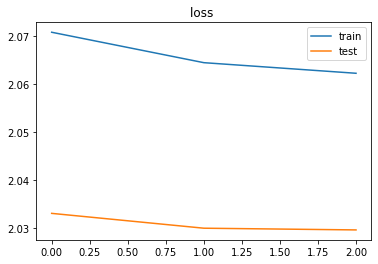

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_X)

In [ ]:
y_pred.shape

(3967088, 1)

In [ ]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_y, y_pred, squared=True);rmse

4.2728157

In [ ]:
# mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred, squared = False);mse

2.067079